<h1>Round 1 (New MASS Spindle Analysis)</h1>

In light of the revised method in the dataset creation, we look to see how this will affect the capabilities and robustness of an artificial neural network OR a support vector machine in the classification of spindles from the 19 MASS subjects. 

The non-spindles and spindles were generated via a 1.0 second moving window with a stride of 0.5 seconds along a 20.0 second epoch. The epochs were extracted ONLY from Stage N2 sleep portions of the patients EEG. The epochs comes from the EEG channel <b>EEG C3-LER</b> (where <b>LER</b> = Linked-Ear Reference). 

In this notebook, we investigate the ability for our chosen classifier to be able to distinguish between spindles and non-spindles PURELY with the QPS parameters as features with which our classifier will learn from. The table of contents below relate to the different stages of our analysis in this notebook.

<h2>Table Of Contents</h2>


<h2>Loading The Dataset</h2>

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Importing libraries for dataset splitting, normalisation and the SVM:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Importing libraries for machine learning via Keras (TensorFlow)
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [3]:
# Importing the raw data as a dataframe:
df = pd.read_csv('first_round.csv')
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.head()

,a,b,c,d,e,f,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,real_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,1.027724,11.901286,-28.891479,-2.355651,82.216834,14.562972,2701.579137,3324.653869,623.074738,0.812590,0.187410,13.085216,14.336918,0.912694,-3.720373,3.724883,1.578702,0.901444,0.0
1,1.526410,-1.887122,-2.130248,2.700008,90.330061,4.995472,2932.713495,3738.649861,805.936392,0.784431,0.215569,14.376476,14.336918,1.002759,-4.738820,4.780801,1.795479,0.885697,0.0
2,0.690444,1.188580,5.157207,-1.862305,86.868018,-22.161481,2251.138916,2906.736742,655.597847,0.774456,0.225544,13.825474,11.264721,1.227325,-5.626445,4.104495,1.619380,0.879851,0.0
3,-0.142231,0.786592,2.370766,1.910112,92.125879,-13.441842,160.526948,4700.534209,4540.007239,0.034151,0.965849,14.662289,11.264721,1.301611,-12.089078,11.653729,4.261459,0.184791,0.0
4,0.206622,-1.015550,8.885345,-7.301421,88.392469,17.900145,2311.846964,3645.338426,1333.491552,0.634193,0.365807,14.068098,10.240655,1.373750,-5.808547,5.592956,2.309538,0.795978,0.0


For this analysis, we will retain JUST the QPS parameters and the associated label as the final dataframe we will be working with throughout the entirity of this notebook. The next following code cells will perform the following:

1. Retain ONLY columns associated with the QPS parameters and the associated label
2. Separate the rows associated with the spindles from those associated with non-spindles
3. Analyse and observe the distribution of the parameter values (that have been generated through this windowing method)

<b>Retained Dataset</b>

In [5]:
# Keeping ONLY the QPS params and label:
desired = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
df = df[desired]
df.head()

,a,b,c,d,e,f,label
0,1.027724,11.901286,-28.891479,-2.355651,82.216834,14.562972,0.0
1,1.526410,-1.887122,-2.130248,2.700008,90.330061,4.995472,0.0
2,0.690444,1.188580,5.157207,-1.862305,86.868018,-22.161481,0.0
3,-0.142231,0.786592,2.370766,1.910112,92.125879,-13.441842,0.0
4,0.206622,-1.015550,8.885345,-7.301421,88.392469,17.900145,0.0


<b>Spindle Subset & Statistics</b>

In [6]:
# Separating spindles from non-spindles:
spindles = df[df['label'] == 1.0].reset_index(drop=True)
non_spindles = df[df['label'] == 0.0].reset_index(drop=True)

# View the spindles dataframe:
spindles.head()

,a,b,c,d,e,f,label
0,2.461181,-5.917009,-10.844330,-0.823453,81.477751,-10.705141,1.0
1,0.627930,-0.456993,6.328750,1.559245,84.141459,-1.744413,1.0
2,1.316426,-8.791128,-58.491670,0.526345,75.804998,11.640195,1.0
3,0.435485,1.851414,-9.690501,-0.911914,92.179978,-5.693132,1.0
4,0.092961,1.446923,2.992225,3.222290,76.871711,-9.492721,1.0


<h3>Statistics For QPS Parameters Of Spindles</h3>

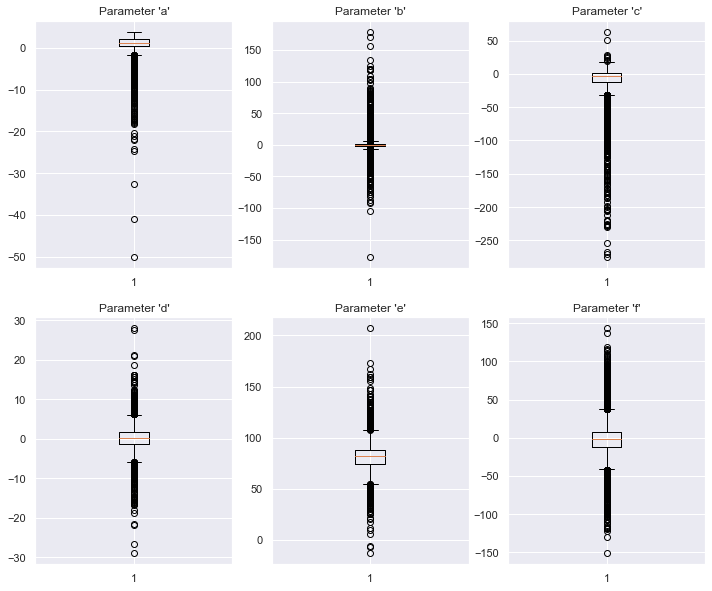

In [7]:
# Generate box plots for each column of the dataframe (other than the label):
fig, ax = plt.subplots(2,3,figsize=(12,10))
k = 0
for i in range(2):
    for j in range(3):
        ax[i,j].boxplot(spindles.iloc[:,k])
        ax[i,j].set_title("Parameter '{}'".format(spindles.columns[k]))
        
        k = k + 1

In [8]:
spindles.describe()

,a,b,c,d,e,f,label
count,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.000000,6539.0
mean,0.925576,1.125606,-11.148034,0.084384,81.506274,-1.708043,1.0
std,2.247371,12.973646,25.907383,2.989449,12.727625,24.545811,0.0
min,-49.999990,-176.871649,-274.442553,-28.994366,-12.885954,-151.110142,1.0
25%,0.462540,-1.415491,-11.948957,-1.366183,74.376264,-11.949741,1.0
50%,1.226794,0.122721,-3.533354,0.118336,82.466621,-1.355895,1.0
75%,1.979127,1.776795,0.763055,1.626105,87.755210,7.865066,1.0
max,3.788441,178.543353,63.092990,27.932573,206.786843,143.241740,1.0


<b>Non-Spindle Subset & Statistics</b>

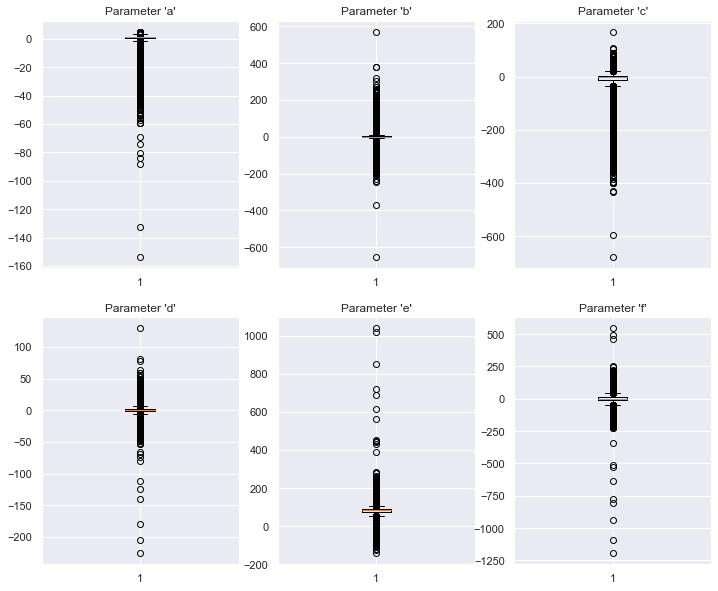

In [9]:
# Generate box plots for each column of the dataframe (other than the label):
fig, ax = plt.subplots(2,3,figsize=(12,10))
k = 0
for i in range(2):
    for j in range(3):
        ax[i,j].boxplot(non_spindles.iloc[:,k])
        ax[i,j].set_title("Parameter '{}'".format(non_spindles.columns[k]))
        
        k = k + 1

In [10]:
non_spindles.describe()

,a,b,c,d,e,f,label
count,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.000000,503942.0
mean,0.674576,1.692259,-12.456343,0.151100,81.391035,-1.367166,0.0
std,2.250449,14.145994,28.755173,2.993734,13.504706,26.543402,0.0
min,-153.432964,-651.651137,-676.674679,-225.576919,-141.801797,-1193.805042,0.0
25%,0.314747,-1.110955,-12.858800,-1.342251,74.054329,-12.548147,0.0
50%,1.003181,0.267752,-3.247733,0.152890,81.967226,-1.069597,0.0
75%,1.669033,2.016054,1.149262,1.681028,87.399892,10.004255,0.0
max,4.889087,569.813494,167.955544,129.281598,1038.470178,544.006231,0.0


<h2>Preparing The Datasets For Machine Learning</h2>

We need pre-process and normalise the datasets for both spindles and non-spindles before we pass the data into a classifier of our choice. First, we need to trim the non-spindle dataset to have the same length as that of the spindle dataset. The way that this notebook is run, the rows will always differ from the run prior. 

In [11]:
# Need to shuffle all rows of the non-spindle dataset first:
non_spindles = non_spindles.sample(frac=1).reset_index(drop=True)

# Then, we need to trim the dataset to be the same length as that of the spindle subset:
non_spindles = non_spindles.iloc[0:len(spindles), :].copy()

# View the non-spindle dataframe:
non_spindles

,a,b,c,d,e,f,label
0,0.526349,-1.588981,-7.804528,0.673488,84.739890,-36.642898,0.0
1,0.506051,-1.154004,-0.232935,3.608476,67.495521,-2.689035,0.0
2,1.455186,2.192433,-25.507095,-0.240950,81.830431,-61.066861,0.0
3,0.418422,15.575469,-54.813077,-1.246485,93.790099,-52.612284,0.0
4,2.003905,2.900224,-10.372689,-1.161284,92.359971,-38.562003,0.0
...,...,...,...,...,...,...,...
6534,-4.864352,-36.445919,-48.811417,0.382551,72.675075,-8.871191,0.0
6535,1.694808,-0.002671,0.995631,0.855587,71.907375,-0.500753,0.0
6536,0.926178,2.205517,-9.890231,2.271339,77.421670,48.210827,0.0
6537,1.173170,-0.254006,-1.985058,-1.371164,73.408245,9.897276,0.0


<h3>Train-Test Split & Normalisation - Support Vector Machine Usage</h3>

In [12]:
# Concatenate the spindle and non-spindle dataset together:
all_df = pd.concat([spindles, non_spindles], axis=0).sample(frac=1).reset_index(drop=True)

# Separate the features from the labels:
X = all_df[['a', 'b', 'c', 'd', 'e', 'f']]
y = all_df['label']

# Take the dataset and make into a training, validation and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [13]:
# Instantiate an empty SVM model
model = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

# Evaluate the accuracy score by cross-validation:
acc_scores_cv = cross_val_score(model, X_train, y_train, cv=5)

<h3>Accuracy Scores (5-Fold Cross Validation)</h3>

In [14]:
print("List Of Accuracies For Each Fold = {}".format(acc_scores_cv))
print("Average Accuracy = {}%".format(round(np.mean(acc_scores_cv), 3)))

List Of Accuracies For Each Fold = [0.55040612 0.55470616 0.54085045 0.54541109 0.53706361]
Average Accuracy = 0.546%


<h3>Scatter Plot Analysis Of QPS Parameter Values</h3>

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


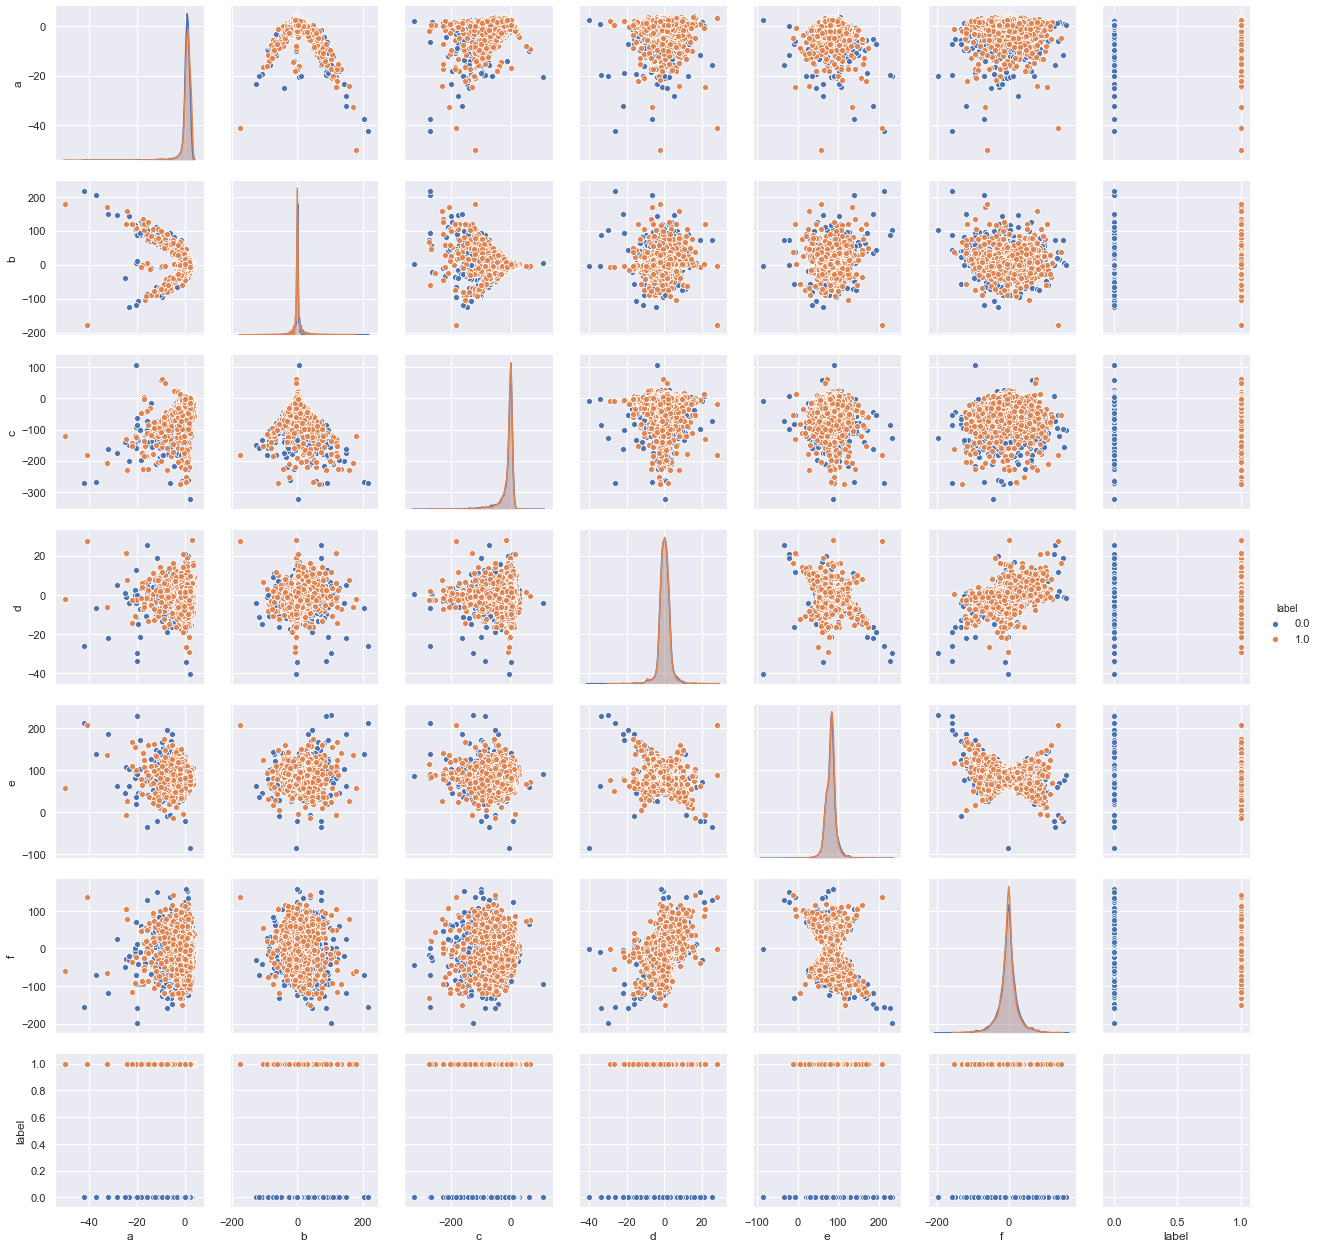

In [15]:
features = ['a', 'b', 'c', 'd', 'e', 'f', 'label']
to_plot = all_df[features].copy()
g = sns.pairplot(to_plot, hue='label')

The above scatter plots above justify the difficulty the classifier has in distinguishing between spindles and non-spindles. The use of the bandpass filter in the 11-16 Hz range in the pre-processing step means that all the frames captured by the moving window will have very similar characteristics to spindles scored by the experts (e.g. same frequency). 

This calls for the use of the other features involving the residual (such as the residual max-min, RSER, QSER, QRFR and so on). Perhaps this measures will better distinguish spindles from non-spindles. 

<h2>Using Other Non-QPS Related Features</h2>

In [16]:
df_etc = pd.read_csv('first_round.csv')
df_etc = df_etc[['qps_energy', 'real_energy',
       'residual_energy', 'qser', 'rser', 'qps_freq_hz', 'real_freq_hz',
       'qrfr', 'min_residual', 'max_residual', 'rms_residual',
       'raw_qps_corrcoeff', 'label']]

In [17]:
df_etc.head()

,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,real_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,2701.579137,3324.653869,623.074738,0.812590,0.187410,13.085216,14.336918,0.912694,-3.720373,3.724883,1.578702,0.901444,0.0
1,2932.713495,3738.649861,805.936392,0.784431,0.215569,14.376476,14.336918,1.002759,-4.738820,4.780801,1.795479,0.885697,0.0
2,2251.138916,2906.736742,655.597847,0.774456,0.225544,13.825474,11.264721,1.227325,-5.626445,4.104495,1.619380,0.879851,0.0
3,160.526948,4700.534209,4540.007239,0.034151,0.965849,14.662289,11.264721,1.301611,-12.089078,11.653729,4.261459,0.184791,0.0
4,2311.846964,3645.338426,1333.491552,0.634193,0.365807,14.068098,10.240655,1.373750,-5.808547,5.592956,2.309538,0.795978,0.0


In [18]:
df_etc_spindles = df_etc[df_etc['label'] == 1.0].reset_index(drop=True)
df_etc_nonspindles = df_etc[df_etc['label'] == 0.0].reset_index(drop=True)

In [21]:
df_etc_nonspindles = df_etc_nonspindles.iloc[0:len(df_etc_spindles), :]

In [22]:
all_df_etc = pd.concat([df_etc_spindles, df_etc_nonspindles], axis=0).reset_index(drop=True)


,qps_energy,real_energy,residual_energy,qser,rser,qps_freq_hz,real_freq_hz,qrfr,min_residual,max_residual,rms_residual,raw_qps_corrcoeff,label
0,30883.883540,32120.237530,1236.353927,0.961509,0.038491,12.967587,13.312852,0.974065,-6.031760,6.120947,2.223829,0.980574,1.0
1,1943.755957,2501.628964,557.872994,0.776996,0.223004,13.391529,13.312852,1.005910,-3.836894,4.294464,1.493818,0.881579,1.0
2,565.062328,794.145203,229.082855,0.711535,0.288465,12.064740,11.264721,1.071020,-2.493749,2.185577,0.957252,0.843537,1.0
3,145.813315,270.237912,124.424600,0.539574,0.460426,14.670899,14.336918,1.023295,-2.117910,1.727661,0.705477,0.734579,1.0
4,421.386834,889.820170,468.433339,0.473564,0.526436,12.234513,11.264721,1.086091,-3.832248,2.726246,1.368844,0.688444,1.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


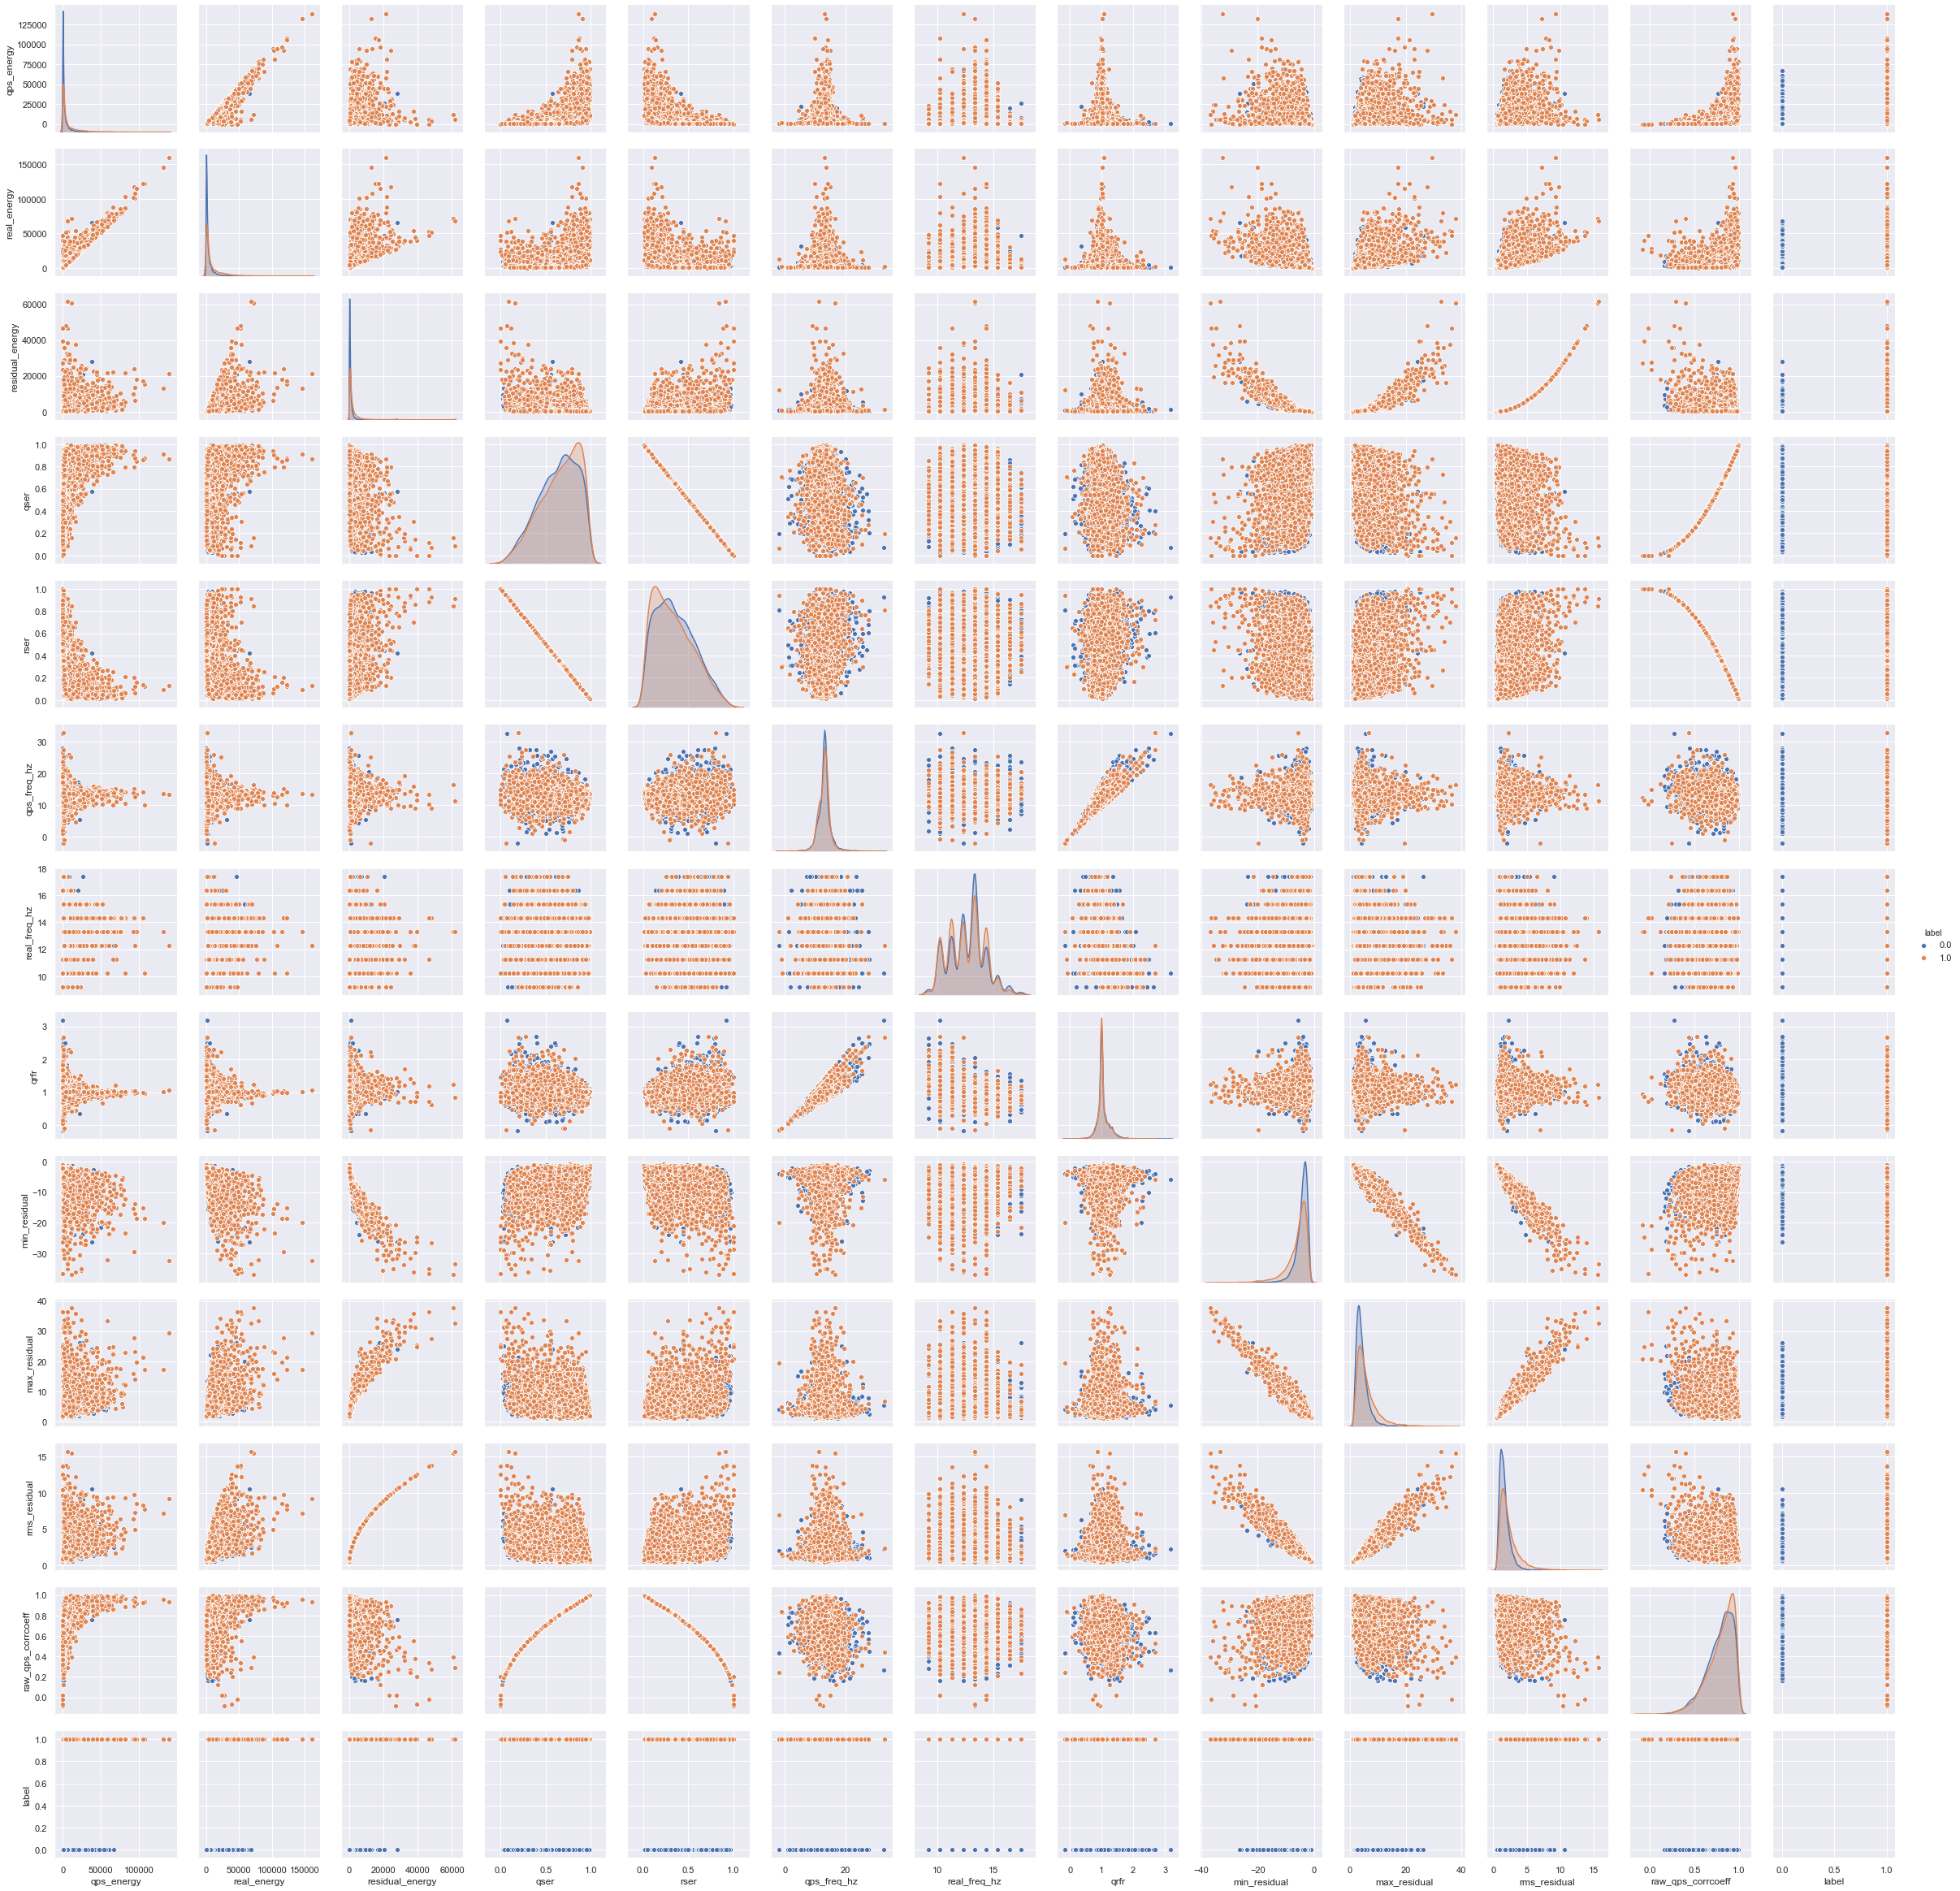

In [24]:
g = sns.pairplot(all_df_etc, hue='label')
plt.show()